# Семантическая сегментация. Домашнее задание

В этом домашнем задании вам нужно будет реализовать и обучить модели сегментации родинок

## Датасет

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# !unzip drive/MyDrive/human_segm.zip
# !mkdir human_dataset
# !mv segmentation_full_body_mads_dataset_1192_img/segmentation_full_body_mads_dataset_1192_img/* human_dataset/
# !rm -rf segmentation_full_body_mads_dataset_1192_img/

In [ ]:
! wget https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar

--2024-05-11 09:26:04--  https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.85.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.85.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/k88qukc20ljnbuo/PH2Dataset.rar [following]
--2024-05-11 09:26:05--  https://www.dropbox.com/s/raw/k88qukc20ljnbuo/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucf59ee994f6a992ea0ac7513346.dl.dropboxusercontent.com/cd/0/inline/CSoeSXcOdoiyjcWCLVTPl4v8ySbk6fl6CmbDF5WLG1Ov3iDPioDOLelScbdiXOVQPngH4ao-DWdW71YOO0uNWXWO9oD4YnevfRjrONcvipm7JzZXymBk227N8Q1eLWrf8Os/file# [following]
--2024-05-11 09:26:05--  https://ucf59ee994f6a992ea0ac7513346.dl.dropboxusercontent.com/cd/0/inline/CSoeSXcOdoiyjcWCLVTPl4v8ySbk6fl6CmbDF5WLG1Ov3iDPioDOLelScbdiXOVQPngH4ao-DWdW71YOO0uNWXWO9oD4YnevfRjrONcvipm7JzZXymB

In [ ]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

In [ ]:
!ls PH2Dataset/PH2\ Dataset\ images | wc -l

200


In [ ]:
images = glob("PH2Dataset/PH2 Dataset images/*")

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from glob import glob
#from torchvision.io import read_image
import cv2
import numpy as np
import os

class HumanDataset(Dataset):
    def __init__(self, images_paths, transform=None, target_transform=None):
        self.image_paths = images_paths
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_name = self.image_paths[idx].split('/')[-1]
        img_path = os.path.join(self.image_paths[idx], img_name + '_Dermoscopic_Image/', img_name + '.bmp')
        image = cv2.imread(img_path)[..., ::-1] / 255
        image = image.astype(np.float32)
        mask_path = img_path.replace(f'_Dermoscopic_Image/', f'_lesion/').replace('.bmp', '_lesion.bmp')
        mask = cv2.imread(mask_path)[..., 0] / 255
        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        return image, torch.unsqueeze(mask, 0)

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

train_transform = A.Compose(
    [
        A.Resize(256, 256),
        ToTensorV2(p=1.0)
    ]
)

val_transform = A.Compose(
    [
        A.Resize(256, 256),
        ToTensorV2()
    ]
)

In [ ]:
import random

random.shuffle(images)
train_images = images[:100]
val_images = images[100:150]
test_images = images[150:]
train_dataset = HumanDataset(train_images, train_transform)
val_dataset = HumanDataset(val_images, val_transform)
test_dataset = HumanDataset(test_images, val_transform)

In [ ]:
img, mask = val_dataset[1]

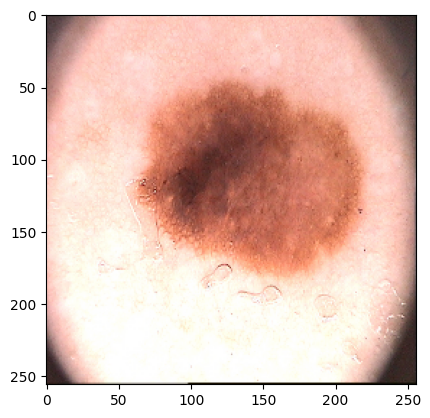

In [ ]:
plt.imshow(img.numpy().transpose(1, 2, 0))

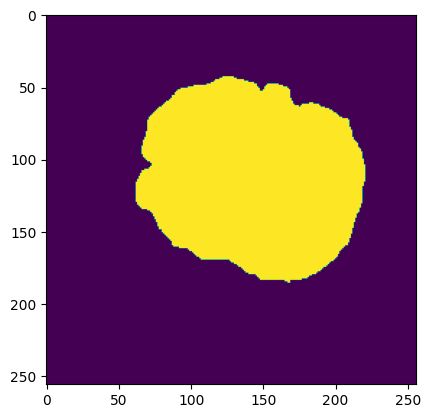

In [ ]:
plt.imshow(mask[0].numpy())

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=1, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=1, drop_last=True)

## Реализация архитектуры U-Net2

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

# from matplotlib import rcParams
# rcParams['figure.figsize'] = (15,4)

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.

In [ ]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool0 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))# 256 -> 128
        self.enc_conv1 =  nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool1 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)) # 128 -> 64
        self.enc_conv2 =  nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.pool2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))  # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.pool3 =  nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))  # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(1024),
            nn.ReLU()
        )

        # decoder (upsampling)
        self.upsample0 =  nn.ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)) # 16 -> 32
        self.dec_conv0 =  nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.upsample1 = nn.ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)) # 32 -> 64
        self.dec_conv1 =  nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
             nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.upsample2 = nn.ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)) # 64 -> 128
        self.dec_conv2 =  nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.upsample3 = nn.ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)) # 128 -> 256
        self.dec_conv3 =  nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0))
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.enc_conv1(self.pool0(e0))
        e2 = self.enc_conv2(self.pool1(e1))
        e3 = self.enc_conv3(self.pool2(e2))

        # bottleneck
        b = self.bottleneck_conv(self.pool3(e3))

        # decoder
        # concatenate over channels dim=1
        d0 = self.dec_conv0(torch.cat([self.upsample0(b), e3], dim=1))
        d1 = self.dec_conv1(torch.cat([self.upsample1(d0), e2], dim=1))
        d2 = self.dec_conv2(torch.cat([self.upsample2(d1), e1], dim=1))
        d3 = self.dec_conv3(torch.cat([self.upsample3(d2), e0], dim=1)) # no activation
        return d3

## Лосс и метрики

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

In [ ]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    bce = torch.max(y_pred, torch.zeros_like(y_pred)) - y_real * y_pred + torch.log(1 + torch.exp(-torch.abs(y_pred)))
    your_loss = (1 - y_real*torch.sigmoid(y_pred) - (1-y_real)*(1 - torch.sigmoid(y_pred)))**gamma * bce
    return torch.clamp(your_loss.mean(), min=0)

**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [ ]:
def dice_loss(y_real, y_pred):
    y_pred = torch.sigmoid(y_pred)
    epsilon = 1e-6
    axes = tuple(range(1,len(y_pred.shape)-1))
    num = torch.sum(2.*y_pred*y_real,axes)
    den =  torch.sum(y_pred+y_real,axes)
    res = torch.mean(1-(num+epsilon)/(den+epsilon))
    return res

Метрика

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0

    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0

    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds

    return thresholded  #

## Функции для обучения

In [ ]:
def visualize(train_loss, val_loss, train_score, val_score, title):
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label = 'train_loss')
    plt.plot(val_loss, label = 'val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_score, label = 'train_score')
    plt.plot(val_score, label = 'val_score')
    plt.title('Score')
    plt.xlabel('Epochs')
    plt.ylabel('Score')

    plt.suptitle(title, fontsize=16)
    plt.legend()
    plt.show()

In [ ]:
#!export LRU_CACHE_CAPACITY=1

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
from IPython.display import clear_output

def train(model, opt, loss_fn, epochs, data_tr, data_val, scheduler, path):
    X_val, Y_val = next(iter(data_val))
    X_val = X_val.to(device)
    Y_val = Y_val.to(device)

    train_loss = []
    val_loss = []
    train_score = []
    val_score = []
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        avg_train_score = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            with torch.set_grad_enabled(True):
                Y_pred = model(X_batch)

                avg_train_score += iou_pytorch(Y_pred>0, Y_batch).mean().item()

                loss =  loss_fn(Y_batch, Y_pred)# forward-pass
                loss.backward()  # backward-pass
                opt.step()  # update weights

                scheduler.step()
        # calculate loss to show the user
            avg_loss += loss / len(data_tr)

        avg_train_score = avg_train_score / len(data_tr)

        train_score.append(avg_train_score)
        train_loss.append(avg_loss)

        toc = time()
        print('loss: %f' % avg_loss)

        avg_val_loss = 0
        avg_val_score = 0
        # show intermediate results
        model.eval()  # testing mode
        with torch.no_grad():
            for X_val_batch, Y_val_batch in data_val:
                # data to device
                X_val_batch = X_val_batch.to(device)
                Y_val_batch = Y_val_batch.to(device)
                # set parameter gradients to zero
                # forward
                Y_val_pred = model(X_val_batch)
                vall_loss =  loss_fn(Y_val_batch, Y_val_pred)# forward-pass
                avg_val_score += iou_pytorch(Y_val_pred >0, Y_val_batch).mean().item()
                # calculate loss to show the user
                avg_val_loss += vall_loss / len(data_val)

        val_loss.append(avg_val_loss)
        avg_val_score = avg_val_score / len(data_val)
        val_score.append(avg_val_score)

        Y_hat = model(X_val).detach().cpu()# detach and put into cpu

        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].cpu().numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0]>0, cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

    torch.save(model, path)
    return train_loss, val_loss, train_score, val_score

In [ ]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

def score_model(model, metric, data):
    #model.eval()  # testing mode
    scores = 0
    with torch.no_grad():
        for X_batch, Y_label in data:
            Y_pred = model(X_batch.to(device))
            scores += metric(Y_pred>0, Y_label.to(device)).mean().item()
    return scores/len(data)

In [ ]:
def model_scorerer(model_class, path, max_epochs, loss, data_tr, data_val):
    model_name = str(model_class).split()[0][:-1]
    loss_name = str(loss).split()[1]
    title = f"Working with {model_name} and {loss_name}"

    model = model_class.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
    train_loss, val_loss, train_score, val_score = \
    train(model, optimizer, loss, max_epochs, data_tr, data_val, scheduler, path)

    # print()
    # visualize(train_loss.cpu().numpy(), val_loss.cpu().numpy(), train_score, val_score, title)

    print(title)
    print(f"validation score: {score_model(model, iou_pytorch, data_val)}")
    return train_loss, val_loss, train_score, val_score, model

## Обучение

In [ ]:
torch.cuda.empty_cache()

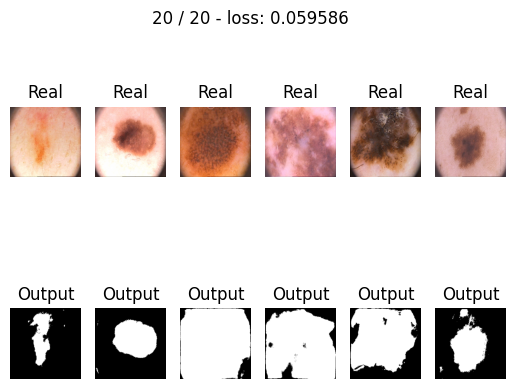

Working with UNet2 and focal_loss
validation score: 0.625000019868215


In [ ]:
train_loss_unet_focal, val_loss_unet_focal, train_score_unet_focal, val_score_unet_focal, model_unet_focal = \
model_scorerer(UNet2(), "unet_focal.pt", 20, focal_loss, train_dataloader, val_dataloader)

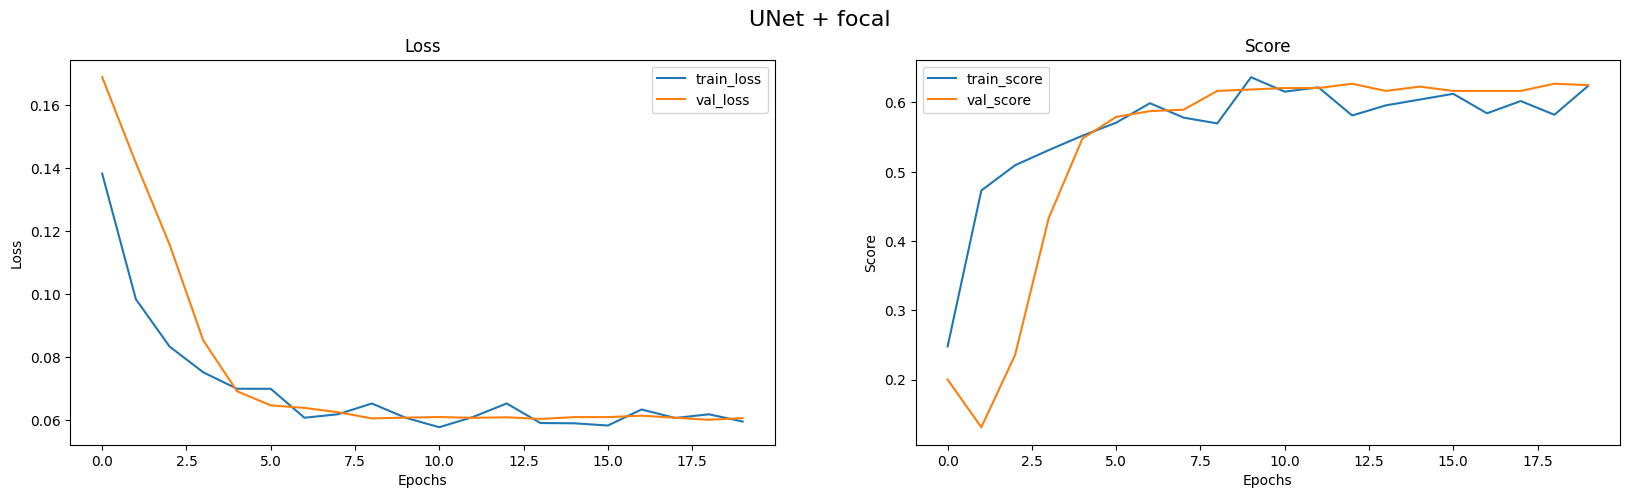

In [ ]:
train_loss_unet_focal = [x.cpu().detach().numpy() for x in train_loss_unet_focal]
val_loss_unet_focal = [x.cpu().detach().numpy() for x in val_loss_unet_focal]

visualize(train_loss_unet_focal, val_loss_unet_focal,
          train_score_unet_focal, val_score_unet_focal, "UNet + focal")

## Обучение с помощью mmsegmentation

### Импорт библиотек

In [ ]:
!pip install torch==2.0.0 torchvision==0.15.1
!pip install -U openmim
!mim install mmengine
!mim install mmcv==2.0.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 78.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 56.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 55.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 76.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.1/177.1 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

Looking in links: https://download.openmmlab.com/mmcv/dist/cu117/torch2.0.0/index.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 451.7/451.7 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 12.8 MB/s eta 0:00:00
Looking in links: https://download.openmmlab.com/mmcv/dist/cu117/torch2.0.0/index.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 MB 4.0 MB/s eta 0:00:00


In [ ]:
!pip install --no-cache-dir mmsegmentation

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 13.3 MB/s eta 0:00:00


In [ ]:
!pip install ftfy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 2.2 MB/s eta 0:00:00


### Модель

In [ ]:
from mmseg.models.backbones import MobileNetV3
from mmseg.models.decode_heads.fcn_head import FCNHead
import torch.nn.functional as F

In [ ]:
import torch
import torch.nn as nn

class TinyModel(nn.Module):

    def __init__(self):
        super(TinyModel, self).__init__()

        self.backbone = MobileNetV3()
        self.head = FCNHead(in_channels=576,
                            channels=128,
                            num_classes=1)

    def forward(self, x):
        x1 = self.backbone(x)
        x2 = self.head(x1)
        x3 = F.interpolate(x2, scale_factor=8, mode='bilinear')
        return x3

In [ ]:
!wget https://download.openmmlab.com/mmsegmentation/v0.5/mobilenet_v3/lraspp_m-v3s-d8_512x1024_320k_cityscapes/lraspp_m-v3s-d8_512x1024_320k_cityscapes_20201224_223935-61565b34.pth

--2024-05-11 09:07:50--  https://download.openmmlab.com/mmsegmentation/v0.5/mobilenet_v3/lraspp_m-v3s-d8_512x1024_320k_cityscapes/lraspp_m-v3s-d8_512x1024_320k_cityscapes_20201224_223935-61565b34.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.246.20.179, 47.246.20.180, 47.246.20.181, ...
Connecting to download.openmmlab.com (download.openmmlab.com)|47.246.20.179|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4666964 (4.5M) [application/octet-stream]
Saving to: ‘lraspp_m-v3s-d8_512x1024_320k_cityscapes_20201224_223935-61565b34.pth’

lraspp_m-v3s-d8_512 100%[===================>]   4.45M  4.44MB/s    in 1.0s    

2024-05-11 09:07:52 (4.44 MB/s) - ‘lraspp_m-v3s-d8_512x1024_320k_cityscapes_20201224_223935-61565b34.pth’ saved [4666964/4666964]



In [ ]:
tiny_model = TinyModel()

/usr/local/lib/python3.10/dist-packages/mmcv/cnn/bricks/hsigmoid.py:35: UserWarning: In MMCV v1.4.4, we modified the default value of args to align with PyTorch official. Previous Implementation: Hsigmoid(x) = min(max((x + 1) / 2, 0), 1). Current Implementation: Hsigmoid(x) = min(max((x + 3) / 6, 0), 1).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/mmseg/models/decode_heads/decode_head.py:136: UserWarning: threshold is not defined for binary, and defaultsto 0.3
  warnings.warn('threshold is not defined for binary, and defaults'
/usr/local/lib/python3.10/dist-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/usr/local/lib/python3.10/dist-packages/mmseg/models/losses/cross_entropy_loss.py:250: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore

In [ ]:
model_name = '/content/lraspp_m-v3s-d8_512x1024_320k_cityscapes_20201224_223935-61565b34.pth'
w = torch.load(model_name, map_location='cpu');
w_backbone = {k.replace('backbone.', ''):v for k,v in w['state_dict'].items() if k.startswith('backbone.')}
tiny_model.backbone.load_state_dict(w_backbone)

<All keys matched successfully>

In [ ]:
tiny_model.to(device)
None

In [ ]:
X_val, Y_val = next(iter(val_dataloader))
X_val = X_val.to(device)
Y_val = Y_val.to(device)

In [ ]:
Y_pred = tiny_model(X_val)

In [ ]:
Y_pred[0].shape

torch.Size([1, 256, 256])

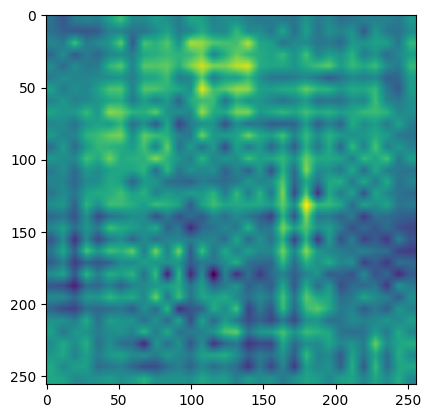

In [ ]:
plt.imshow(Y_pred[0][0].detach().cpu().numpy())

### Обучение

In [ ]:
def model_scorerer(model, model_name, path, max_epochs, loss, data_tr, data_val):
    loss_name = str(loss).split()[1]
    title = f"Working with {model_name} and {loss_name}"

    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
    train_loss, val_loss, train_score, val_score = \
    train(model, optimizer, loss, max_epochs, data_tr, data_val, scheduler, path)

    # print()
    # visualize(train_loss.cpu().numpy(), val_loss.cpu().numpy(), train_score, val_score, title)

    print(title)
    print(f"validation score: {score_model(model, iou_pytorch, data_val)}")
    return train_loss, val_loss, train_score, val_score, model

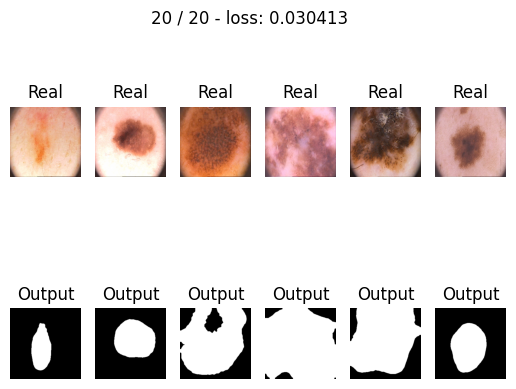

Working with MobileNet+FCNHead and focal_loss
validation score: 0.6979166766007742


In [ ]:
train_loss, val_loss, train_score, val_score, model = \
model_scorerer(tiny_model, "MobileNet+FCNHead", "MobileNet+FCNHead.pt", 20, focal_loss, train_dataloader, val_dataloader)

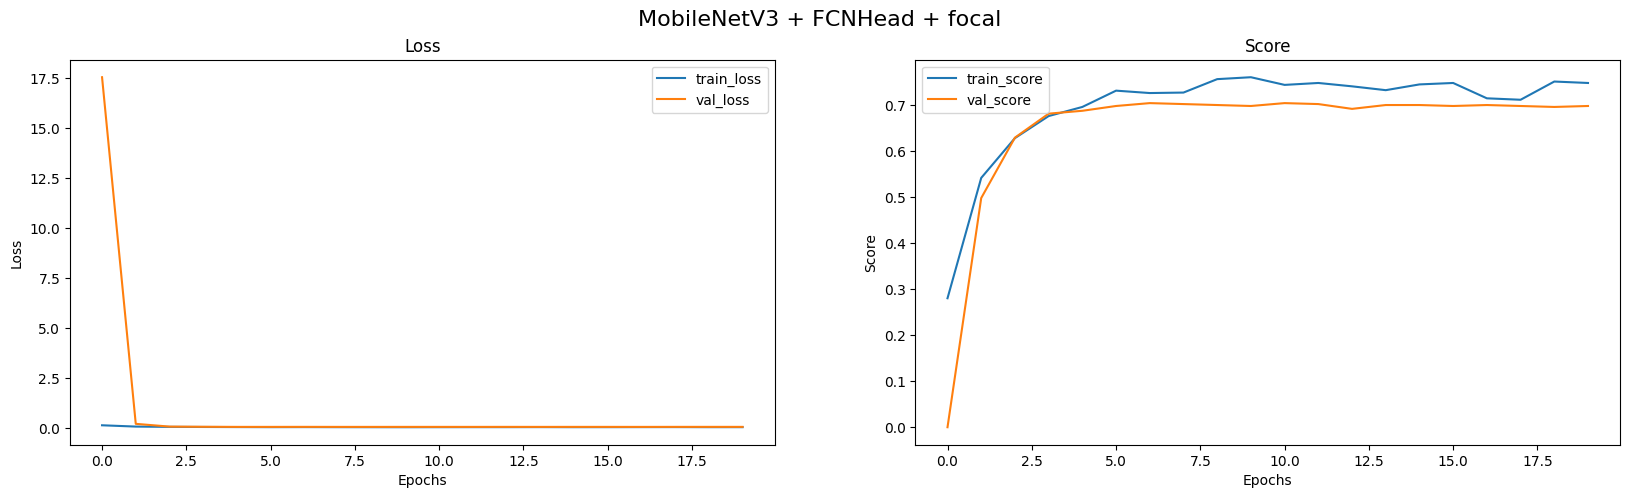

In [ ]:
train_loss = [x.cpu().detach().numpy() for x in train_loss]
val_loss = [x.cpu().detach().numpy() for x in val_loss]

visualize(train_loss, val_loss,
          train_score, val_score, "MobileNetV3 + FCNHead + focal")